# Лабораторная работа №6

Изучение поведения доверительных интервалов при изменении размера выборки и 
величины доверительной вероятности. Исследование действительного значения 
доверительной вероятности при отклонении условий построения доверительного 
интервала от предполагаемых. 

1. Генерировать выборки из разных распределений разного размера. Построить 
доверительные интервалы для математического ожидания (с коэффициентом Стьюдента) 
по каждой из выборок. Построить зависимость ширины интервала от размера выборки, от 
величины доверительной вероятности. 

2. Исследовать, совпадает ли назначенное значение доверительной вероятности (Q = 0,95) 
с реально достигаемым. Для этого сгенерировать для каждого значения размера выборки 
из набора (n = 10, 20, 30, 50, 60) большое количество выборок ($N = 10^3$) и посчитать, какое 
количество из них будет в самом деле содержать точное значение математического 
ожидания. 

Распределения, из которых следует генерировать выборки: нормальный с нулевым 
математическим ожиданием и произвольной дисперсией; равномерный на [-1, +1].

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from pathlib import Path
from tqdm.contrib.concurrent import process_map
import scipy

np.random.seed(42)

In [2]:
TRUE_MU = 0
TRUE_SIGMA = 1
UNIFORM_LOW = -1
UNIFORM_HIGH = 1
CONFIDENCE_PROBS = [0.90, 0.95, 0.99]
SAMPLE_SIZES = [10, 20, 30, 50, 100, 200]
NUM_EXPERIMENTS = 1000

OUT_DIR = Path("lab-6")
OUT_DIR.mkdir(parents=True, exist_ok=True)

Подготовка данных

In [ ]:
def build_confidence_interval(sample, confidence_prob):
    n = len(sample)
    mean = np.mean(sample)
    # unbiased std estimate by sample
    std_mean = np.std(sample, ddof=1) / np.sqrt(n)

    t_coeff = scipy.stats.t.ppf((1 + confidence_prob) / 2, df=n - 1)
    
    margin = t_coeff * std_mean
    lower = mean - margin
    upper = mean + margin
    width = upper - lower
    
    return mean, lower, upper, width

def experiment(args):
    n, conf_prob, i = args
    res = []

    sample = np.random.normal(loc=TRUE_MU, scale=TRUE_SIGMA, size=n)
    mean, lower, upper, width = build_confidence_interval(sample, conf_prob)
    contains = (lower <= TRUE_MU <= upper)
    res.append(("norm", n, conf_prob, i, mean, lower, upper, width, contains))

    sample = np.random.uniform(UNIFORM_LOW, UNIFORM_HIGH, size=n)
    mean, lower, upper, width = build_confidence_interval(sample, conf_prob)
    contains = (lower <= (UNIFORM_HIGH + UNIFORM_LOW) / 2 <= upper)
    res.append(("uni", n, conf_prob, i, mean, lower, upper, width, contains))

    return res

In [45]:
args = list(itertools.product(SAMPLE_SIZES, CONFIDENCE_PROBS, range(NUM_EXPERIMENTS)))
rss = process_map(experiment, args, chunksize=10)

100%|██████████| 18000/18000 [01:26<00:00, 207.41it/s]


In [46]:
results = [r for rs in rss for r in rs]
df_ci = pd.DataFrame(results, columns=["dist", "n", "conf_prob", "iter", "mean", "lower", "upper", "width", "contains"])
df_ci.to_csv(OUT_DIR / "ci-2.csv", index=False)
df_ci.sample(5)

,dist,n,conf_prob,iter,mean,lower,upper,width,contains
5033,uni,10,0.99,516,-0.293874,-0.865970,0.278221,1.144192,True
23124,norm,50,0.99,562,-0.073195,-0.461748,0.315357,0.777104,True
4015,uni,10,0.99,7,-0.059349,-0.645387,0.526690,1.172077,True
8549,uni,20,0.95,274,-0.022073,-0.323060,0.278914,0.601974,True
22106,norm,50,0.99,53,0.128701,-0.235863,0.493265,0.729129,True


In [49]:
df_ci = pd.read_csv(OUT_DIR / "ci.csv")

### Часть 1. Зависимость ДИ от размера выборки

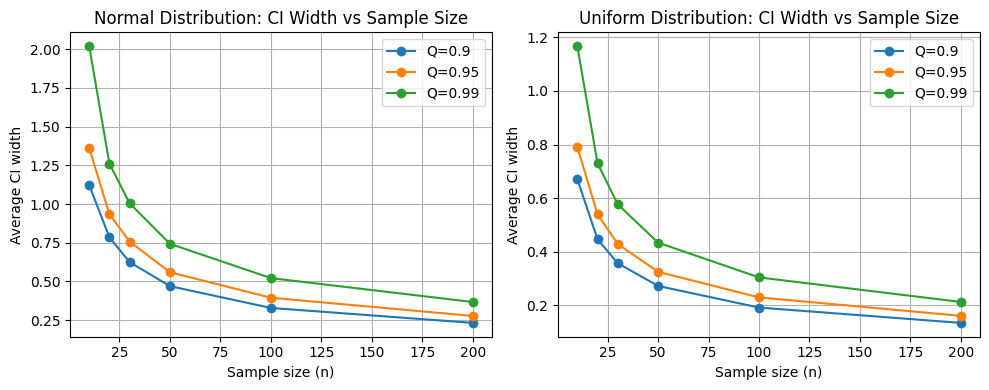

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

def analyze_ci(ax, df: pd.DataFrame, title: str):
    for conf_prob in CONFIDENCE_PROBS:
        subset = df[df["conf_prob"] == conf_prob]
        avg_widths = subset.groupby("n")["width"].mean()
        ax.plot(avg_widths.index, avg_widths.values, marker="o", label=f"Q={conf_prob}")

    ax.set_xlabel("Sample size (n)")
    ax.set_ylabel("Average CI width")
    ax.set_title(title)
    ax.legend()
    ax.grid(True)

analyze_ci(axes[0], df_ci[df_ci["dist"] == "norm"], "Normal Distribution: CI Width vs Sample Size")
analyze_ci(axes[1], df_ci[df_ci["dist"] == "uni"], "Uniform Distribution: CI Width vs Sample Size")

plt.tight_layout()
plt.show()

### Часть 2. Покрытие ДИ

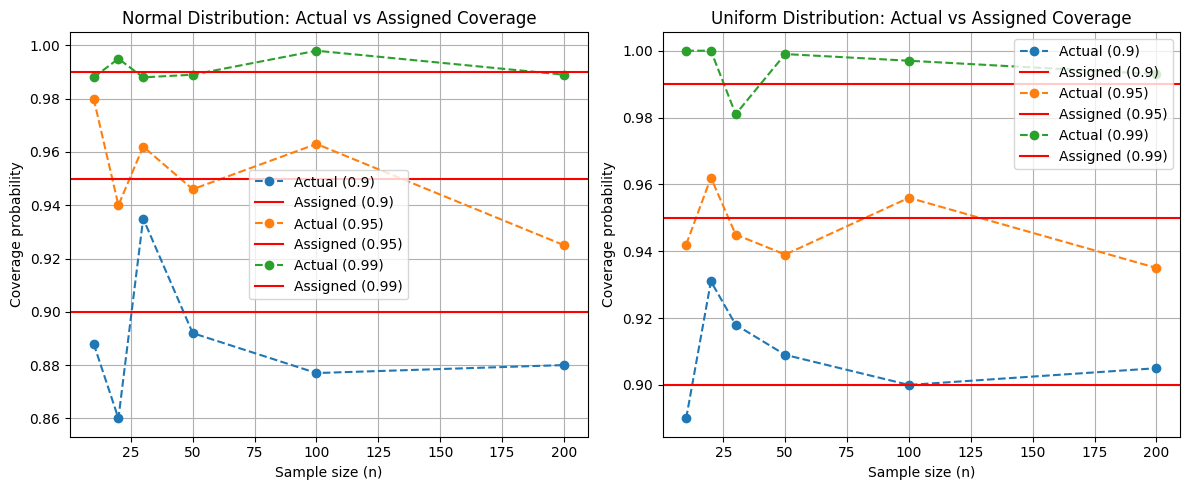

In [59]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

def analyze_ci_2(ax, df: pd.Series, title: str):
    for cb in CONFIDENCE_PROBS:
        sub = df[df["conf_prob"] == cb]
        ax.plot(sub["n"], sub["contains"], linestyle="--", marker="o", label=f"Actual ({cb})")
        ax.axhline(y=cb, color="r", linestyle="-", label=f"Assigned ({cb})")
        ax.set_xlabel("Sample size (n)")
        ax.set_ylabel("Coverage probability")
        ax.set_title(title)
        ax.legend()
        ax.grid(True)

analyze_ci_2(axes[0], (
    df_ci[df_ci["dist"] == "norm"]
    .groupby(["n", "conf_prob"], as_index=False)["contains"]
    .mean()
), "Normal Distribution: Actual vs Assigned Coverage")

analyze_ci_2(axes[1], (
    df_ci[df_ci["dist"] == "uni"]
    .groupby(["n", "conf_prob"], as_index=False)["contains"]
    .mean()
), "Uniform Distribution: Actual vs Assigned Coverage")

plt.tight_layout()
plt.show()

## Вывод

1. При $n \to \infty$ сужается доверительный интервал
2. Вероятность построения по выборке доверительного интервала, покрывающего точное значение оцениваемого параметра распределения (мат. ожидания) близка к доверительной вероятности этого интервала.